<h2>NASnet-A implementation</h2>

<p>Training NASnet on CIFAR-100.<p>
<pre>
<i>[1] Barret Zoph, Vijay Vasudevan, Jonathon Shlens, Quoc V. Le,
   "Learning Transferable Architectures for Scalable Image Recognition"
   <a href="https://arxiv.org/abs/1707.07012">https://arxiv.org/abs/1707.07012</a>
</i>
</pre>

In [122]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets,transforms, models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import sys
import argparse
import time
from torch.autograd import Variable
from torch.optim.lr_scheduler import _LRScheduler

<h3>Hyperparameter Settings</h3>

In [107]:
batchsize = 128
max_epochs = 10
l_r = 0.1
w = 1

<h3>Loading and preprocessing data:</h3>
<p>Let us calculate the mean and standard deviation of the dataset. We'll use this in the transforms later.</p>

In [108]:
def compute_mean_std(dataset):
    
    data_r = np.dstack([np.array(im)[:, :, 0]/255 for im,label in dataset])
    data_g = np.dstack([np.array(im)[:, :, 1]/255 for im,label in dataset])
    data_b = np.dstack([np.array(im)[:, :, 2]/255 for im,label in dataset])
    
    mean = [np.asscalar(np.mean(data_r)), np.asscalar(np.mean(data_g)), np.asscalar(np.mean(data_b))]
    std = [np.asscalar(np.std(data_r)), np.asscalar(np.std(data_g)), np.asscalar(np.std(data_b))]
    
    return mean,std

In [109]:
#cifar_norm_train=datasets.CIFAR100(data_dir, train=True, transform=None, target_transform=None, download=False)
#cifar_norm_test=datasets.CIFAR100(data_dir, train=False, transform=None, target_transform=None, download=False)
#train_mean,train_std = compute_mean_std(cifar_norm_train)
#test_mean, test_std = compute_mean_std(cifar_norm_test)
#print(train_mean,train_std)
#print(test_mean,test_std)

[0.5070751592371341, 0.48654887331495067, 0.4409178433670344] [0.2673342858792403, 0.2564384629170882, 0.27615047132568393]
[0.508796412760417, 0.48739301317401906, 0.4419422112438727] [0.2682515741720801, 0.25736373644781246, 0.2770957707973041]


In [112]:
#No need to calculate this multiple times, by saving the mean/std values
train_mean,train_std = [0.5070751592371341, 0.48654887331495067, 0.4409178433670344],[0.2673342858792403, 0.2564384629170882, 0.27615047132568393]
test_mean, test_std = [0.508796412760417, 0.48739301317401906, 0.4419422112438727],[0.2682515741720801, 0.25736373644781246, 0.2770957707973041]

Padding with 4 zeros, taking 32 by 32 crops, random flipping and normalization by values found above.

In [113]:
train_transforms = transforms.Compose([transforms.Pad(4,fill=0),
                                     transforms.RandomResizedCrop(32),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(train_mean,train_std)])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(test_mean,test_std)])

In [114]:
data_dir='../input/cifar-100-python/'
cifar_train=datasets.CIFAR100(data_dir, train=True, transform=train_transforms, target_transform=None, download=False)
cifar_test=datasets.CIFAR100(data_dir, train=False, transform=test_transforms, target_transform=None, download=False)

2

In [115]:
trainloader = torch.utils.data.DataLoader(cifar_train, batch_size=batchsize, shuffle=True)
testloader = torch.utils.data.DataLoader(cifar_test, batch_size=batchsize, shuffle=True)

<h3>Visualizing CIFAR</h3>
<p>Just to see what's actually in there.</p>

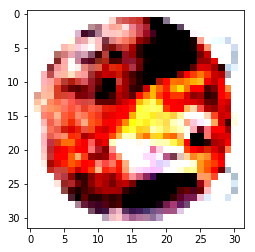

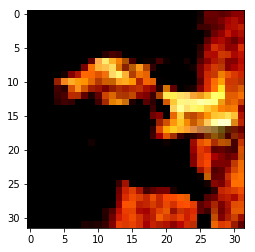

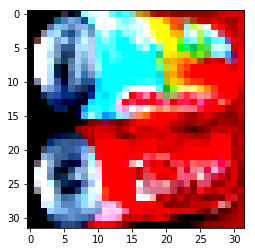

In [116]:
for inputs,labels in testloader:
    break
images = inputs.numpy()
for i in range(3):
    plt.figure()
    plt.imshow(images[i].T)

<h3>NASnet Class Implementation</h3>

In [117]:
class SeperableConv2d(nn.Module):

    def __init__(self, input_channels, output_channels, kernel_size, **kwargs):

        super().__init__()
        self.depthwise = nn.Conv2d(
            input_channels,
            input_channels,
            kernel_size,
            groups=input_channels,
            **kwargs
        )

        self.pointwise = nn.Conv2d(
            input_channels,
            output_channels,
            1
        )
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)

        return x

class SeperableBranch(nn.Module):

    def __init__(self, input_channels, output_channels, kernel_size, **kwargs):
        """Adds 2 blocks of [relu-separable conv-batchnorm]."""
        super().__init__()
        self.block1 = nn.Sequential(
            nn.ReLU(),
            SeperableConv2d(input_channels, output_channels, kernel_size, **kwargs),
            nn.BatchNorm2d(output_channels)
        )

        self.block2 = nn.Sequential(
            nn.ReLU(),
            SeperableConv2d(output_channels, output_channels, kernel_size, stride=1, padding=int(kernel_size / 2)),
            nn.BatchNorm2d(output_channels)
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)

        return x

class Fit(nn.Module):
    """Make the cell outputs compatible

    Args:
        prev_filters: filter number of tensor prev, needs to be modified
        filters: filter number of normal cell branch output filters
    """

    def __init__(self, prev_filters, filters):
        super().__init__()
        self.relu = nn.ReLU()

        self.p1 = nn.Sequential(
            nn.AvgPool2d(1, stride=2),
            nn.Conv2d(prev_filters, int(filters / 2), 1)
        )

        #make sure there is no information loss
        self.p2 = nn.Sequential(
            nn.ConstantPad2d((0, 1, 0, 1), 0),
            nn.ConstantPad2d((-1, 0, -1, 0), 0),   #cropping
            nn.AvgPool2d(1, stride=2),
            nn.Conv2d(prev_filters, int(filters / 2), 1)
        )

        self.bn = nn.BatchNorm2d(filters)

        self.dim_reduce = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(prev_filters, filters, 1),
            nn.BatchNorm2d(filters)
        )

        self.filters = filters
    
    def forward(self, inputs):
        x, prev = inputs
        if prev is None:
            return x

        #image size does not match
        elif x.size(2) != prev.size(2):
            prev = self.relu(prev)
            p1 = self.p1(prev)
            p2 = self.p2(prev)
            prev = torch.cat([p1, p2], 1)
            prev = self.bn(prev)

        elif prev.size(1) != self.filters:
            prev = self.dim_reduce(prev)

        return prev


class NormalCell(nn.Module):

    def __init__(self, x_in, prev_in, output_channels):
        super().__init__()

        self.dem_reduce = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(x_in, output_channels, 1, bias=False),
            nn.BatchNorm2d(output_channels)
        )

        self.block1_left = SeperableBranch(
            output_channels, 
            output_channels,
            kernel_size=3,
            padding=1,
            bias=False
        )
        self.block1_right = nn.Sequential()

        self.block2_left = SeperableBranch(
            output_channels,
            output_channels,
            kernel_size=3,
            padding=1,
            bias=False
        )
        self.block2_right = SeperableBranch(
            output_channels,
            output_channels,
            kernel_size=5,
            padding=2,
            bias=False
        )

        self.block3_left = nn.AvgPool2d(3, stride=1, padding=1)
        self.block3_right = nn.Sequential()

        self.block4_left = nn.AvgPool2d(3, stride=1, padding=1)
        self.block4_right = nn.AvgPool2d(3, stride=1, padding=1)

        self.block5_left = SeperableBranch(
            output_channels,
            output_channels,
            kernel_size=5,
            padding=2,
            bias=False
        )
        self.block5_right = SeperableBranch(
            output_channels,
            output_channels,
            kernel_size=3,
            padding=1,
            bias=False
        )

        self.fit = Fit(prev_in, output_channels)
    
    def forward(self, x):
        x, prev = x

        #return transformed x as new x, and original x as prev 
        #only prev tensor needs to be modified
        prev = self.fit((x, prev)) 

        h = self.dem_reduce(x)

        x1 = self.block1_left(h) + self.block1_right(h)
        x2 = self.block2_left(prev) + self.block2_right(h)
        x3 = self.block3_left(h) + self.block3_right(h)
        x4 = self.block4_left(prev) + self.block4_right(prev)
        x5 = self.block5_left(prev) + self.block5_right(prev)

        return torch.cat([prev, x1, x2, x3, x4, x5], 1), x

class ReductionCell(nn.Module):

    def __init__(self, x_in, prev_in, output_channels):
        super().__init__()

        self.dim_reduce = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(x_in, output_channels, 1),
            nn.BatchNorm2d(output_channels)
        )

        #block1
        self.layer1block1_left = SeperableBranch(output_channels, output_channels, 7, stride=2, padding=3)
        self.layer1block1_right = SeperableBranch(output_channels, output_channels, 5, stride=2, padding=2)

        #block2
        self.layer1block2_left = nn.MaxPool2d(3, stride=2, padding=1)
        self.layer1block2_right = SeperableBranch(output_channels, output_channels, 7, stride=2, padding=3)

        #block3
        self.layer1block3_left = nn.AvgPool2d(3, 2, 1)
        self.layer1block3_right = SeperableBranch(output_channels, output_channels, 5, stride=2, padding=2)

        #block5
        self.layer2block1_left = nn.MaxPool2d(3, 2, 1)
        self.layer2block1_right = SeperableBranch(output_channels, output_channels, 3, stride=1, padding=1)

        #block4
        self.layer2block2_left = nn.AvgPool2d(3, 1, 1)
        self.layer2block2_right = nn.Sequential()
    
        self.fit = Fit(prev_in, output_channels)
    
    def forward(self, x):
        x, prev = x
        prev = self.fit((x, prev))

        h = self.dim_reduce(x)

        layer1block1 = self.layer1block1_left(prev) + self.layer1block1_right(h)
        layer1block2 = self.layer1block2_left(h) + self.layer1block2_right(prev)
        layer1block3 = self.layer1block3_left(h) + self.layer1block3_right(prev)
        layer2block1 = self.layer2block1_left(h) + self.layer2block1_right(layer1block1)
        layer2block2 = self.layer2block2_left(layer1block1) + self.layer2block2_right(layer1block2)

        return torch.cat([
            layer1block2, #https://github.com/keras-team/keras-applications/blob/master/keras_applications/nasnet.py line 739
            layer1block3,
            layer2block1,
            layer2block2
        ], 1), x


class NasNetA(nn.Module):

    def __init__(self, repeat_cell_num, reduction_num, filters, stemfilter, class_num=100):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, stemfilter, 3, padding=1, bias=False),
            nn.BatchNorm2d(stemfilter)
        )

        self.prev_filters = stemfilter
        self.x_filters = stemfilter
        self.filters = filters

        self.cell_layers = self._make_layers(repeat_cell_num, reduction_num)

        self.relu = nn.ReLU()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(self.filters * 6, class_num)
    
    
    def _make_normal(self, block, repeat, output):
        """make normal cell
        Args:
            block: cell type
            repeat: number of repeated normal cell
            output: output filters for each branch in normal cell
        Returns:
            stacked normal cells
        """

        layers = [] 
        for r in range(repeat):
            layers.append(block(self.x_filters, self.prev_filters, output))
            self.prev_filters = self.x_filters
            self.x_filters = output * 6 #concatenate 6 branches
        
        return layers

    def _make_reduction(self, block, output):
        """make normal cell
        Args:
            block: cell type
            output: output filters for each branch in reduction cell
        Returns:
            reduction cell
        """

        reduction = block(self.x_filters, self.prev_filters, output)
        self.prev_filters = self.x_filters
        self.x_filters = output * 4 #stack for 4 branches

        return reduction
    
    def _make_layers(self, repeat_cell_num, reduction_num):

        layers = []
        for i in range(reduction_num):

            layers.extend(self._make_normal(NormalCell, repeat_cell_num, self.filters))
            self.filters *= 2
            layers.append(self._make_reduction(ReductionCell, self.filters))
        
        layers.extend(self._make_normal(NormalCell, repeat_cell_num, self.filters))

        return nn.Sequential(*layers)


    def forward(self, x):

        x = self.stem(x)
        prev = None
        x, prev = self.cell_layers((x, prev))
        x = self.relu(x)
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
        
        
def nasnet():

    #stem filters must be 44, it's a pytorch workaround, cant change to other number
    return NasNetA(4, 2, 44, 44) 

In [118]:
class WarmUpLR(_LRScheduler):
    """warmup_training learning rate scheduler
    Args:
        optimizer: optimzier(e.g. SGD)
        total_iters: totoal_iters of warmup phase
    """
    def __init__(self, optimizer, total_iters, last_epoch=-1):
        
        self.total_iters = total_iters
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        """we will use the first m batches, and set the learning
        rate to base_lr * m / total_iters
        """
        return [base_lr * self.last_epoch / (self.total_iters + 1e-8) for base_lr in self.base_lrs]

<h3>Training</h3>

In [119]:
def train(epoch):
    net.train()
    
    for batch_index, (images, labels) in enumerate(trainloader):
        if epoch <= w:
            warmup_scheduler.step()
            print('warmed up')
        
        print('start')
        images = Variable(images)
        labels = Variable(labels)
        
        labels = labels.cuda()
        images = images.cuda()

        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        n_iter = (epoch - 1) * len(trainloader) + batch_index + 1

        last_layer = list(net.children())[-1]

        print('Training Epoch: {epoch} [{trained_samples}/{total_samples}]\tLoss: {:0.4f}\tLR: {:0.6f}'.format(
            loss.item(),
            optimizer.param_groups[0]['lr'],
            epoch=epoch,
            trained_samples=batch_index * batchsize + len(images),
            total_samples=len(trainloader.dataset)
        ))
        
    
def eval_training(epoch):
    net.eval()

    test_loss = 0.0 # cost function error
    correct = 0.0
    k= 0
    with torch.no_grad():
        for images, labels in testloader:
            #images = Variable(images)
            #labels = Variable(labels)
       
            temp = net(images)
            loss = loss_function(temp, labels)
            test_loss += loss.item()
            _, preds = temp.max(1)
            del temp
        torch.cuda.empty_cache()
        correct += preds.eq(labels).sum()
        k=k+1
        if k%10 == 0:
            print(k)

    print('Test set: Average loss: {:.4f}, Accuracy: {:.4f}'.format(
        test_loss / len(trainloader.dataset),
        correct.float() / len(testloader.dataset)
    ))
    return correct.float() / len(testloader.dataset)

In [135]:
def cheatloss(epoch):
    for batch_index, (images, labels) in enumerate(trainloader):
        print('start')
        outputs = net(images)
        loss = loss_function(outputs, labels)
        return loss

In [125]:
net = nasnet()
net = net.cuda()
k = '1'

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
train_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2) #learning rate decay
iter_per_epoch = len(trainloader)
warmup_scheduler = WarmUpLR(optimizer, iter_per_epoch * w)
checkpoint_path = os.path.join('checkpoint', 'nasnet', k)

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
checkpoint_path = os.path.join(checkpoint_path, '{net}-{epoch}-{type}.pth')

best_acc = 0.0
start = time.time()
for epoch in range(1,max_epochs):
    if epoch > 1:
         train_scheduler.step(epoch)
    train(epoch)
end = time.time()
print('Trained in: ',str(end-start))
#acc = eval_training(epoch)
    

warmed up
start
Training Epoch: 1 [128/50000]	Loss: 4.6222	LR: 0.000256
warmed up
start
Training Epoch: 1 [256/50000]	Loss: 4.6528	LR: 0.000512
warmed up
start
Training Epoch: 1 [384/50000]	Loss: 4.6002	LR: 0.000767
warmed up
start
Training Epoch: 1 [512/50000]	Loss: 4.6249	LR: 0.001023
warmed up
start
Training Epoch: 1 [640/50000]	Loss: 4.6113	LR: 0.001279
warmed up
start
Training Epoch: 1 [768/50000]	Loss: 4.6222	LR: 0.001535
warmed up
start
Training Epoch: 1 [896/50000]	Loss: 4.6270	LR: 0.001790
warmed up
start
Training Epoch: 1 [1024/50000]	Loss: 4.6044	LR: 0.002046
warmed up
start
Training Epoch: 1 [1152/50000]	Loss: 4.5853	LR: 0.002302
warmed up
start
Training Epoch: 1 [1280/50000]	Loss: 4.6182	LR: 0.002558
warmed up
start
Training Epoch: 1 [1408/50000]	Loss: 4.6216	LR: 0.002813
warmed up
start
Training Epoch: 1 [1536/50000]	Loss: 4.5830	LR: 0.003069
warmed up
start
Training Epoch: 1 [1664/50000]	Loss: 4.5906	LR: 0.003325
warmed up
start
Training Epoch: 1 [1792/50000]	Loss: 4.547

Training Epoch: 1 [14464/50000]	Loss: 4.3432	LR: 0.028900
warmed up
start
Training Epoch: 1 [14592/50000]	Loss: 4.1217	LR: 0.029156
warmed up
start
Training Epoch: 1 [14720/50000]	Loss: 4.2659	LR: 0.029412
warmed up
start
Training Epoch: 1 [14848/50000]	Loss: 4.1902	LR: 0.029668
warmed up
start
Training Epoch: 1 [14976/50000]	Loss: 4.1011	LR: 0.029923
warmed up
start
Training Epoch: 1 [15104/50000]	Loss: 4.3971	LR: 0.030179
warmed up
start
Training Epoch: 1 [15232/50000]	Loss: 4.1705	LR: 0.030435
warmed up
start
Training Epoch: 1 [15360/50000]	Loss: 4.0520	LR: 0.030691
warmed up
start
Training Epoch: 1 [15488/50000]	Loss: 4.2583	LR: 0.030946
warmed up
start
Training Epoch: 1 [15616/50000]	Loss: 4.1697	LR: 0.031202
warmed up
start
Training Epoch: 1 [15744/50000]	Loss: 4.3344	LR: 0.031458
warmed up
start
Training Epoch: 1 [15872/50000]	Loss: 4.2294	LR: 0.031714
warmed up
start
Training Epoch: 1 [16000/50000]	Loss: 4.2726	LR: 0.031969
warmed up
start
Training Epoch: 1 [16128/50000]	Loss: 

Training Epoch: 1 [28672/50000]	Loss: 3.8326	LR: 0.057289
warmed up
start
Training Epoch: 1 [28800/50000]	Loss: 3.9207	LR: 0.057545
warmed up
start
Training Epoch: 1 [28928/50000]	Loss: 4.1554	LR: 0.057801
warmed up
start
Training Epoch: 1 [29056/50000]	Loss: 4.0990	LR: 0.058056
warmed up
start
Training Epoch: 1 [29184/50000]	Loss: 4.1516	LR: 0.058312
warmed up
start
Training Epoch: 1 [29312/50000]	Loss: 3.9569	LR: 0.058568
warmed up
start
Training Epoch: 1 [29440/50000]	Loss: 4.0428	LR: 0.058824
warmed up
start
Training Epoch: 1 [29568/50000]	Loss: 4.0849	LR: 0.059079
warmed up
start
Training Epoch: 1 [29696/50000]	Loss: 4.0724	LR: 0.059335
warmed up
start
Training Epoch: 1 [29824/50000]	Loss: 4.1225	LR: 0.059591
warmed up
start
Training Epoch: 1 [29952/50000]	Loss: 3.9553	LR: 0.059847
warmed up
start
Training Epoch: 1 [30080/50000]	Loss: 3.8207	LR: 0.060102
warmed up
start
Training Epoch: 1 [30208/50000]	Loss: 3.8901	LR: 0.060358
warmed up
start
Training Epoch: 1 [30336/50000]	Loss: 

Training Epoch: 1 [42880/50000]	Loss: 3.9336	LR: 0.085678
warmed up
start
Training Epoch: 1 [43008/50000]	Loss: 3.7304	LR: 0.085934
warmed up
start
Training Epoch: 1 [43136/50000]	Loss: 3.9397	LR: 0.086189
warmed up
start
Training Epoch: 1 [43264/50000]	Loss: 3.9037	LR: 0.086445
warmed up
start
Training Epoch: 1 [43392/50000]	Loss: 4.0778	LR: 0.086701
warmed up
start
Training Epoch: 1 [43520/50000]	Loss: 3.8357	LR: 0.086957
warmed up
start
Training Epoch: 1 [43648/50000]	Loss: 4.0148	LR: 0.087212
warmed up
start
Training Epoch: 1 [43776/50000]	Loss: 4.0105	LR: 0.087468
warmed up
start
Training Epoch: 1 [43904/50000]	Loss: 3.8485	LR: 0.087724
warmed up
start
Training Epoch: 1 [44032/50000]	Loss: 3.9709	LR: 0.087980
warmed up
start
Training Epoch: 1 [44160/50000]	Loss: 3.7811	LR: 0.088235
warmed up
start
Training Epoch: 1 [44288/50000]	Loss: 3.9464	LR: 0.088491
warmed up
start
Training Epoch: 1 [44416/50000]	Loss: 3.7663	LR: 0.088747
warmed up
start
Training Epoch: 1 [44544/50000]	Loss: 

Training Epoch: 2 [8320/50000]	Loss: 3.4196	LR: 0.100000
start
Training Epoch: 2 [8448/50000]	Loss: 3.2847	LR: 0.100000
start
Training Epoch: 2 [8576/50000]	Loss: 3.7479	LR: 0.100000
start
Training Epoch: 2 [8704/50000]	Loss: 3.8264	LR: 0.100000
start
Training Epoch: 2 [8832/50000]	Loss: 3.8865	LR: 0.100000
start
Training Epoch: 2 [8960/50000]	Loss: 3.7353	LR: 0.100000
start
Training Epoch: 2 [9088/50000]	Loss: 3.5706	LR: 0.100000
start
Training Epoch: 2 [9216/50000]	Loss: 3.7604	LR: 0.100000
start
Training Epoch: 2 [9344/50000]	Loss: 3.6543	LR: 0.100000
start
Training Epoch: 2 [9472/50000]	Loss: 3.6137	LR: 0.100000
start
Training Epoch: 2 [9600/50000]	Loss: 3.6695	LR: 0.100000
start
Training Epoch: 2 [9728/50000]	Loss: 3.7087	LR: 0.100000
start
Training Epoch: 2 [9856/50000]	Loss: 3.8474	LR: 0.100000
start
Training Epoch: 2 [9984/50000]	Loss: 3.6483	LR: 0.100000
start
Training Epoch: 2 [10112/50000]	Loss: 3.7157	LR: 0.100000
start
Training Epoch: 2 [10240/50000]	Loss: 3.5732	LR: 0.100

Training Epoch: 2 [24832/50000]	Loss: 3.4292	LR: 0.100000
start
Training Epoch: 2 [24960/50000]	Loss: 3.3104	LR: 0.100000
start
Training Epoch: 2 [25088/50000]	Loss: 3.6835	LR: 0.100000
start
Training Epoch: 2 [25216/50000]	Loss: 3.4154	LR: 0.100000
start
Training Epoch: 2 [25344/50000]	Loss: 3.4947	LR: 0.100000
start
Training Epoch: 2 [25472/50000]	Loss: 3.5742	LR: 0.100000
start
Training Epoch: 2 [25600/50000]	Loss: 3.3285	LR: 0.100000
start
Training Epoch: 2 [25728/50000]	Loss: 3.6773	LR: 0.100000
start
Training Epoch: 2 [25856/50000]	Loss: 3.3978	LR: 0.100000
start
Training Epoch: 2 [25984/50000]	Loss: 3.5107	LR: 0.100000
start
Training Epoch: 2 [26112/50000]	Loss: 3.5474	LR: 0.100000
start
Training Epoch: 2 [26240/50000]	Loss: 3.7578	LR: 0.100000
start
Training Epoch: 2 [26368/50000]	Loss: 3.3968	LR: 0.100000
start
Training Epoch: 2 [26496/50000]	Loss: 3.4923	LR: 0.100000
start
Training Epoch: 2 [26624/50000]	Loss: 3.6455	LR: 0.100000
start
Training Epoch: 2 [26752/50000]	Loss: 3.

Training Epoch: 2 [41344/50000]	Loss: 3.2753	LR: 0.100000
start
Training Epoch: 2 [41472/50000]	Loss: 3.3701	LR: 0.100000
start
Training Epoch: 2 [41600/50000]	Loss: 3.5047	LR: 0.100000
start
Training Epoch: 2 [41728/50000]	Loss: 3.3786	LR: 0.100000
start
Training Epoch: 2 [41856/50000]	Loss: 3.3848	LR: 0.100000
start
Training Epoch: 2 [41984/50000]	Loss: 3.3592	LR: 0.100000
start
Training Epoch: 2 [42112/50000]	Loss: 3.4269	LR: 0.100000
start
Training Epoch: 2 [42240/50000]	Loss: 3.5172	LR: 0.100000
start
Training Epoch: 2 [42368/50000]	Loss: 3.4500	LR: 0.100000
start
Training Epoch: 2 [42496/50000]	Loss: 3.4548	LR: 0.100000
start
Training Epoch: 2 [42624/50000]	Loss: 3.4555	LR: 0.100000
start
Training Epoch: 2 [42752/50000]	Loss: 3.4472	LR: 0.100000
start
Training Epoch: 2 [42880/50000]	Loss: 3.2848	LR: 0.100000
start
Training Epoch: 2 [43008/50000]	Loss: 3.2001	LR: 0.100000
start
Training Epoch: 2 [43136/50000]	Loss: 3.3864	LR: 0.100000
start
Training Epoch: 2 [43264/50000]	Loss: 3.

Training Epoch: 3 [7936/50000]	Loss: 3.5455	LR: 0.100000
start
Training Epoch: 3 [8064/50000]	Loss: 3.4352	LR: 0.100000
start
Training Epoch: 3 [8192/50000]	Loss: 3.2088	LR: 0.100000
start
Training Epoch: 3 [8320/50000]	Loss: 3.2500	LR: 0.100000
start
Training Epoch: 3 [8448/50000]	Loss: 3.0834	LR: 0.100000
start
Training Epoch: 3 [8576/50000]	Loss: 2.9137	LR: 0.100000
start
Training Epoch: 3 [8704/50000]	Loss: 3.3169	LR: 0.100000
start
Training Epoch: 3 [8832/50000]	Loss: 3.1892	LR: 0.100000
start
Training Epoch: 3 [8960/50000]	Loss: 3.3555	LR: 0.100000
start
Training Epoch: 3 [9088/50000]	Loss: 3.1894	LR: 0.100000
start
Training Epoch: 3 [9216/50000]	Loss: 2.9062	LR: 0.100000
start
Training Epoch: 3 [9344/50000]	Loss: 3.1698	LR: 0.100000
start
Training Epoch: 3 [9472/50000]	Loss: 3.1829	LR: 0.100000
start
Training Epoch: 3 [9600/50000]	Loss: 3.1199	LR: 0.100000
start
Training Epoch: 3 [9728/50000]	Loss: 3.0327	LR: 0.100000
start
Training Epoch: 3 [9856/50000]	Loss: 3.2670	LR: 0.10000

Training Epoch: 3 [24448/50000]	Loss: 3.2690	LR: 0.100000
start
Training Epoch: 3 [24576/50000]	Loss: 3.0059	LR: 0.100000
start
Training Epoch: 3 [24704/50000]	Loss: 3.1659	LR: 0.100000
start
Training Epoch: 3 [24832/50000]	Loss: 3.1172	LR: 0.100000
start
Training Epoch: 3 [24960/50000]	Loss: 3.1681	LR: 0.100000
start
Training Epoch: 3 [25088/50000]	Loss: 3.1528	LR: 0.100000
start
Training Epoch: 3 [25216/50000]	Loss: 3.1339	LR: 0.100000
start
Training Epoch: 3 [25344/50000]	Loss: 3.3069	LR: 0.100000
start
Training Epoch: 3 [25472/50000]	Loss: 3.1323	LR: 0.100000
start
Training Epoch: 3 [25600/50000]	Loss: 3.0596	LR: 0.100000
start
Training Epoch: 3 [25728/50000]	Loss: 2.9496	LR: 0.100000
start
Training Epoch: 3 [25856/50000]	Loss: 3.1098	LR: 0.100000
start
Training Epoch: 3 [25984/50000]	Loss: 3.3980	LR: 0.100000
start
Training Epoch: 3 [26112/50000]	Loss: 3.0986	LR: 0.100000
start
Training Epoch: 3 [26240/50000]	Loss: 3.2771	LR: 0.100000
start
Training Epoch: 3 [26368/50000]	Loss: 3.

Training Epoch: 3 [40960/50000]	Loss: 2.8683	LR: 0.100000
start
Training Epoch: 3 [41088/50000]	Loss: 3.0779	LR: 0.100000
start
Training Epoch: 3 [41216/50000]	Loss: 2.7954	LR: 0.100000
start
Training Epoch: 3 [41344/50000]	Loss: 2.8430	LR: 0.100000
start
Training Epoch: 3 [41472/50000]	Loss: 2.9897	LR: 0.100000
start
Training Epoch: 3 [41600/50000]	Loss: 3.0877	LR: 0.100000
start
Training Epoch: 3 [41728/50000]	Loss: 2.9299	LR: 0.100000
start
Training Epoch: 3 [41856/50000]	Loss: 3.0629	LR: 0.100000
start
Training Epoch: 3 [41984/50000]	Loss: 3.1042	LR: 0.100000
start
Training Epoch: 3 [42112/50000]	Loss: 3.1813	LR: 0.100000
start
Training Epoch: 3 [42240/50000]	Loss: 3.0854	LR: 0.100000
start
Training Epoch: 3 [42368/50000]	Loss: 3.1898	LR: 0.100000
start
Training Epoch: 3 [42496/50000]	Loss: 2.8447	LR: 0.100000
start
Training Epoch: 3 [42624/50000]	Loss: 2.8436	LR: 0.100000
start
Training Epoch: 3 [42752/50000]	Loss: 2.9661	LR: 0.100000
start
Training Epoch: 3 [42880/50000]	Loss: 3.

Training Epoch: 4 [7552/50000]	Loss: 2.8877	LR: 0.100000
start
Training Epoch: 4 [7680/50000]	Loss: 2.9376	LR: 0.100000
start
Training Epoch: 4 [7808/50000]	Loss: 3.2932	LR: 0.100000
start
Training Epoch: 4 [7936/50000]	Loss: 3.1361	LR: 0.100000
start
Training Epoch: 4 [8064/50000]	Loss: 2.7486	LR: 0.100000
start
Training Epoch: 4 [8192/50000]	Loss: 2.5825	LR: 0.100000
start
Training Epoch: 4 [8320/50000]	Loss: 2.6273	LR: 0.100000
start
Training Epoch: 4 [8448/50000]	Loss: 3.0576	LR: 0.100000
start
Training Epoch: 4 [8576/50000]	Loss: 2.7458	LR: 0.100000
start
Training Epoch: 4 [8704/50000]	Loss: 2.9270	LR: 0.100000
start
Training Epoch: 4 [8832/50000]	Loss: 2.9165	LR: 0.100000
start
Training Epoch: 4 [8960/50000]	Loss: 2.9224	LR: 0.100000
start
Training Epoch: 4 [9088/50000]	Loss: 3.0894	LR: 0.100000
start
Training Epoch: 4 [9216/50000]	Loss: 2.9388	LR: 0.100000
start
Training Epoch: 4 [9344/50000]	Loss: 3.0582	LR: 0.100000
start
Training Epoch: 4 [9472/50000]	Loss: 3.0055	LR: 0.10000

Training Epoch: 4 [24064/50000]	Loss: 2.8710	LR: 0.100000
start
Training Epoch: 4 [24192/50000]	Loss: 2.8124	LR: 0.100000
start
Training Epoch: 4 [24320/50000]	Loss: 2.8168	LR: 0.100000
start
Training Epoch: 4 [24448/50000]	Loss: 2.8483	LR: 0.100000
start
Training Epoch: 4 [24576/50000]	Loss: 2.6250	LR: 0.100000
start
Training Epoch: 4 [24704/50000]	Loss: 2.9954	LR: 0.100000
start
Training Epoch: 4 [24832/50000]	Loss: 2.8468	LR: 0.100000
start
Training Epoch: 4 [24960/50000]	Loss: 2.6512	LR: 0.100000
start
Training Epoch: 4 [25088/50000]	Loss: 2.9574	LR: 0.100000
start
Training Epoch: 4 [25216/50000]	Loss: 2.8663	LR: 0.100000
start
Training Epoch: 4 [25344/50000]	Loss: 2.8826	LR: 0.100000
start
Training Epoch: 4 [25472/50000]	Loss: 2.9933	LR: 0.100000
start
Training Epoch: 4 [25600/50000]	Loss: 2.6744	LR: 0.100000
start
Training Epoch: 4 [25728/50000]	Loss: 3.0510	LR: 0.100000
start
Training Epoch: 4 [25856/50000]	Loss: 2.8141	LR: 0.100000
start
Training Epoch: 4 [25984/50000]	Loss: 2.

Training Epoch: 4 [40576/50000]	Loss: 2.8411	LR: 0.100000
start
Training Epoch: 4 [40704/50000]	Loss: 2.7784	LR: 0.100000
start
Training Epoch: 4 [40832/50000]	Loss: 2.6545	LR: 0.100000
start
Training Epoch: 4 [40960/50000]	Loss: 2.6468	LR: 0.100000
start
Training Epoch: 4 [41088/50000]	Loss: 2.8048	LR: 0.100000
start
Training Epoch: 4 [41216/50000]	Loss: 2.9786	LR: 0.100000
start
Training Epoch: 4 [41344/50000]	Loss: 2.5618	LR: 0.100000
start
Training Epoch: 4 [41472/50000]	Loss: 2.7349	LR: 0.100000
start
Training Epoch: 4 [41600/50000]	Loss: 2.9070	LR: 0.100000
start
Training Epoch: 4 [41728/50000]	Loss: 2.6887	LR: 0.100000
start
Training Epoch: 4 [41856/50000]	Loss: 2.6155	LR: 0.100000
start
Training Epoch: 4 [41984/50000]	Loss: 2.8079	LR: 0.100000
start
Training Epoch: 4 [42112/50000]	Loss: 2.6336	LR: 0.100000
start
Training Epoch: 4 [42240/50000]	Loss: 2.6540	LR: 0.100000
start
Training Epoch: 4 [42368/50000]	Loss: 2.8730	LR: 0.100000
start
Training Epoch: 4 [42496/50000]	Loss: 2.

Training Epoch: 5 [7040/50000]	Loss: 2.6510	LR: 0.100000
start
Training Epoch: 5 [7168/50000]	Loss: 2.8825	LR: 0.100000
start
Training Epoch: 5 [7296/50000]	Loss: 2.5860	LR: 0.100000
start
Training Epoch: 5 [7424/50000]	Loss: 2.6051	LR: 0.100000
start
Training Epoch: 5 [7552/50000]	Loss: 2.6728	LR: 0.100000
start
Training Epoch: 5 [7680/50000]	Loss: 2.6309	LR: 0.100000
start
Training Epoch: 5 [7808/50000]	Loss: 2.7713	LR: 0.100000
start
Training Epoch: 5 [7936/50000]	Loss: 2.6268	LR: 0.100000
start
Training Epoch: 5 [8064/50000]	Loss: 2.5467	LR: 0.100000
start
Training Epoch: 5 [8192/50000]	Loss: 2.9341	LR: 0.100000
start
Training Epoch: 5 [8320/50000]	Loss: 2.9059	LR: 0.100000
start
Training Epoch: 5 [8448/50000]	Loss: 2.7750	LR: 0.100000
start
Training Epoch: 5 [8576/50000]	Loss: 2.4703	LR: 0.100000
start
Training Epoch: 5 [8704/50000]	Loss: 2.4900	LR: 0.100000
start
Training Epoch: 5 [8832/50000]	Loss: 2.8228	LR: 0.100000
start
Training Epoch: 5 [8960/50000]	Loss: 2.5713	LR: 0.10000

Training Epoch: 5 [23552/50000]	Loss: 2.5463	LR: 0.100000
start
Training Epoch: 5 [23680/50000]	Loss: 2.7007	LR: 0.100000
start
Training Epoch: 5 [23808/50000]	Loss: 2.5706	LR: 0.100000
start
Training Epoch: 5 [23936/50000]	Loss: 2.6530	LR: 0.100000
start
Training Epoch: 5 [24064/50000]	Loss: 2.6851	LR: 0.100000
start
Training Epoch: 5 [24192/50000]	Loss: 2.5804	LR: 0.100000
start
Training Epoch: 5 [24320/50000]	Loss: 2.6992	LR: 0.100000
start
Training Epoch: 5 [24448/50000]	Loss: 2.5157	LR: 0.100000
start
Training Epoch: 5 [24576/50000]	Loss: 2.8598	LR: 0.100000
start
Training Epoch: 5 [24704/50000]	Loss: 2.6140	LR: 0.100000
start
Training Epoch: 5 [24832/50000]	Loss: 2.9450	LR: 0.100000
start
Training Epoch: 5 [24960/50000]	Loss: 2.4952	LR: 0.100000
start
Training Epoch: 5 [25088/50000]	Loss: 2.6650	LR: 0.100000
start
Training Epoch: 5 [25216/50000]	Loss: 2.6270	LR: 0.100000
start
Training Epoch: 5 [25344/50000]	Loss: 2.4579	LR: 0.100000
start
Training Epoch: 5 [25472/50000]	Loss: 2.

Training Epoch: 5 [40064/50000]	Loss: 2.4874	LR: 0.100000
start
Training Epoch: 5 [40192/50000]	Loss: 2.4055	LR: 0.100000
start
Training Epoch: 5 [40320/50000]	Loss: 2.5133	LR: 0.100000
start
Training Epoch: 5 [40448/50000]	Loss: 2.7078	LR: 0.100000
start
Training Epoch: 5 [40576/50000]	Loss: 2.3703	LR: 0.100000
start
Training Epoch: 5 [40704/50000]	Loss: 2.4731	LR: 0.100000
start
Training Epoch: 5 [40832/50000]	Loss: 2.4861	LR: 0.100000
start
Training Epoch: 5 [40960/50000]	Loss: 2.8350	LR: 0.100000
start
Training Epoch: 5 [41088/50000]	Loss: 2.6752	LR: 0.100000
start
Training Epoch: 5 [41216/50000]	Loss: 2.4704	LR: 0.100000
start
Training Epoch: 5 [41344/50000]	Loss: 2.6862	LR: 0.100000
start
Training Epoch: 5 [41472/50000]	Loss: 2.5425	LR: 0.100000
start
Training Epoch: 5 [41600/50000]	Loss: 2.6562	LR: 0.100000
start
Training Epoch: 5 [41728/50000]	Loss: 2.5413	LR: 0.100000
start
Training Epoch: 5 [41856/50000]	Loss: 2.4913	LR: 0.100000
start
Training Epoch: 5 [41984/50000]	Loss: 2.

Training Epoch: 6 [6528/50000]	Loss: 2.5739	LR: 0.100000
start
Training Epoch: 6 [6656/50000]	Loss: 2.4999	LR: 0.100000
start
Training Epoch: 6 [6784/50000]	Loss: 2.5938	LR: 0.100000
start
Training Epoch: 6 [6912/50000]	Loss: 2.3523	LR: 0.100000
start
Training Epoch: 6 [7040/50000]	Loss: 2.4366	LR: 0.100000
start
Training Epoch: 6 [7168/50000]	Loss: 2.6160	LR: 0.100000
start
Training Epoch: 6 [7296/50000]	Loss: 2.5680	LR: 0.100000
start
Training Epoch: 6 [7424/50000]	Loss: 2.5611	LR: 0.100000
start
Training Epoch: 6 [7552/50000]	Loss: 2.5245	LR: 0.100000
start
Training Epoch: 6 [7680/50000]	Loss: 2.4255	LR: 0.100000
start
Training Epoch: 6 [7808/50000]	Loss: 2.4307	LR: 0.100000
start
Training Epoch: 6 [7936/50000]	Loss: 2.2740	LR: 0.100000
start
Training Epoch: 6 [8064/50000]	Loss: 2.4414	LR: 0.100000
start
Training Epoch: 6 [8192/50000]	Loss: 2.3130	LR: 0.100000
start
Training Epoch: 6 [8320/50000]	Loss: 2.3667	LR: 0.100000
start
Training Epoch: 6 [8448/50000]	Loss: 2.2768	LR: 0.10000

Training Epoch: 6 [23040/50000]	Loss: 2.4519	LR: 0.100000
start
Training Epoch: 6 [23168/50000]	Loss: 2.4306	LR: 0.100000
start
Training Epoch: 6 [23296/50000]	Loss: 2.5694	LR: 0.100000
start
Training Epoch: 6 [23424/50000]	Loss: 2.6083	LR: 0.100000
start
Training Epoch: 6 [23552/50000]	Loss: 2.5271	LR: 0.100000
start
Training Epoch: 6 [23680/50000]	Loss: 2.3569	LR: 0.100000
start
Training Epoch: 6 [23808/50000]	Loss: 2.3862	LR: 0.100000
start
Training Epoch: 6 [23936/50000]	Loss: 2.6541	LR: 0.100000
start
Training Epoch: 6 [24064/50000]	Loss: 2.4871	LR: 0.100000
start
Training Epoch: 6 [24192/50000]	Loss: 2.4517	LR: 0.100000
start
Training Epoch: 6 [24320/50000]	Loss: 2.3923	LR: 0.100000
start
Training Epoch: 6 [24448/50000]	Loss: 2.4800	LR: 0.100000
start
Training Epoch: 6 [24576/50000]	Loss: 2.5169	LR: 0.100000
start
Training Epoch: 6 [24704/50000]	Loss: 2.6266	LR: 0.100000
start
Training Epoch: 6 [24832/50000]	Loss: 2.3361	LR: 0.100000
start
Training Epoch: 6 [24960/50000]	Loss: 2.

Training Epoch: 6 [39552/50000]	Loss: 2.6925	LR: 0.100000
start
Training Epoch: 6 [39680/50000]	Loss: 2.1679	LR: 0.100000
start
Training Epoch: 6 [39808/50000]	Loss: 2.5472	LR: 0.100000
start
Training Epoch: 6 [39936/50000]	Loss: 2.5910	LR: 0.100000
start
Training Epoch: 6 [40064/50000]	Loss: 2.3453	LR: 0.100000
start
Training Epoch: 6 [40192/50000]	Loss: 2.3652	LR: 0.100000
start
Training Epoch: 6 [40320/50000]	Loss: 2.7461	LR: 0.100000
start
Training Epoch: 6 [40448/50000]	Loss: 2.3932	LR: 0.100000
start
Training Epoch: 6 [40576/50000]	Loss: 2.5613	LR: 0.100000
start
Training Epoch: 6 [40704/50000]	Loss: 2.6124	LR: 0.100000
start
Training Epoch: 6 [40832/50000]	Loss: 2.5704	LR: 0.100000
start
Training Epoch: 6 [40960/50000]	Loss: 2.3686	LR: 0.100000
start
Training Epoch: 6 [41088/50000]	Loss: 2.4202	LR: 0.100000
start
Training Epoch: 6 [41216/50000]	Loss: 2.4318	LR: 0.100000
start
Training Epoch: 6 [41344/50000]	Loss: 2.4606	LR: 0.100000
start
Training Epoch: 6 [41472/50000]	Loss: 2.

Training Epoch: 7 [6016/50000]	Loss: 2.4591	LR: 0.100000
start
Training Epoch: 7 [6144/50000]	Loss: 2.1911	LR: 0.100000
start
Training Epoch: 7 [6272/50000]	Loss: 2.3485	LR: 0.100000
start
Training Epoch: 7 [6400/50000]	Loss: 2.2408	LR: 0.100000
start
Training Epoch: 7 [6528/50000]	Loss: 2.0421	LR: 0.100000
start
Training Epoch: 7 [6656/50000]	Loss: 2.4070	LR: 0.100000
start
Training Epoch: 7 [6784/50000]	Loss: 2.4513	LR: 0.100000
start
Training Epoch: 7 [6912/50000]	Loss: 2.1854	LR: 0.100000
start
Training Epoch: 7 [7040/50000]	Loss: 2.3650	LR: 0.100000
start
Training Epoch: 7 [7168/50000]	Loss: 2.4344	LR: 0.100000
start
Training Epoch: 7 [7296/50000]	Loss: 2.4191	LR: 0.100000
start
Training Epoch: 7 [7424/50000]	Loss: 2.4820	LR: 0.100000
start
Training Epoch: 7 [7552/50000]	Loss: 2.4300	LR: 0.100000
start
Training Epoch: 7 [7680/50000]	Loss: 2.4982	LR: 0.100000
start
Training Epoch: 7 [7808/50000]	Loss: 2.5105	LR: 0.100000
start
Training Epoch: 7 [7936/50000]	Loss: 2.5911	LR: 0.10000

Training Epoch: 7 [22528/50000]	Loss: 2.6117	LR: 0.100000
start
Training Epoch: 7 [22656/50000]	Loss: 2.4131	LR: 0.100000
start
Training Epoch: 7 [22784/50000]	Loss: 2.3859	LR: 0.100000
start
Training Epoch: 7 [22912/50000]	Loss: 2.3647	LR: 0.100000
start
Training Epoch: 7 [23040/50000]	Loss: 2.3788	LR: 0.100000
start
Training Epoch: 7 [23168/50000]	Loss: 2.3277	LR: 0.100000
start
Training Epoch: 7 [23296/50000]	Loss: 2.2172	LR: 0.100000
start
Training Epoch: 7 [23424/50000]	Loss: 2.2164	LR: 0.100000
start
Training Epoch: 7 [23552/50000]	Loss: 2.5636	LR: 0.100000
start
Training Epoch: 7 [23680/50000]	Loss: 2.4414	LR: 0.100000
start
Training Epoch: 7 [23808/50000]	Loss: 2.5544	LR: 0.100000
start
Training Epoch: 7 [23936/50000]	Loss: 2.4256	LR: 0.100000
start
Training Epoch: 7 [24064/50000]	Loss: 2.5907	LR: 0.100000
start
Training Epoch: 7 [24192/50000]	Loss: 2.3479	LR: 0.100000
start
Training Epoch: 7 [24320/50000]	Loss: 2.3794	LR: 0.100000
start
Training Epoch: 7 [24448/50000]	Loss: 2.

Training Epoch: 7 [39040/50000]	Loss: 2.3620	LR: 0.100000
start
Training Epoch: 7 [39168/50000]	Loss: 2.3826	LR: 0.100000
start
Training Epoch: 7 [39296/50000]	Loss: 2.2410	LR: 0.100000
start
Training Epoch: 7 [39424/50000]	Loss: 2.2996	LR: 0.100000
start
Training Epoch: 7 [39552/50000]	Loss: 2.3089	LR: 0.100000
start
Training Epoch: 7 [39680/50000]	Loss: 2.5045	LR: 0.100000
start
Training Epoch: 7 [39808/50000]	Loss: 2.0483	LR: 0.100000
start
Training Epoch: 7 [39936/50000]	Loss: 2.2004	LR: 0.100000
start
Training Epoch: 7 [40064/50000]	Loss: 2.2736	LR: 0.100000
start
Training Epoch: 7 [40192/50000]	Loss: 2.1145	LR: 0.100000
start
Training Epoch: 7 [40320/50000]	Loss: 2.3064	LR: 0.100000
start
Training Epoch: 7 [40448/50000]	Loss: 2.3306	LR: 0.100000
start
Training Epoch: 7 [40576/50000]	Loss: 2.1758	LR: 0.100000
start
Training Epoch: 7 [40704/50000]	Loss: 2.3730	LR: 0.100000
start
Training Epoch: 7 [40832/50000]	Loss: 2.2944	LR: 0.100000
start
Training Epoch: 7 [40960/50000]	Loss: 2.

Training Epoch: 8 [5504/50000]	Loss: 2.2539	LR: 0.100000
start
Training Epoch: 8 [5632/50000]	Loss: 2.3694	LR: 0.100000
start
Training Epoch: 8 [5760/50000]	Loss: 2.2869	LR: 0.100000
start
Training Epoch: 8 [5888/50000]	Loss: 2.4184	LR: 0.100000
start
Training Epoch: 8 [6016/50000]	Loss: 2.4012	LR: 0.100000
start
Training Epoch: 8 [6144/50000]	Loss: 2.2855	LR: 0.100000
start
Training Epoch: 8 [6272/50000]	Loss: 2.4169	LR: 0.100000
start
Training Epoch: 8 [6400/50000]	Loss: 2.1621	LR: 0.100000
start
Training Epoch: 8 [6528/50000]	Loss: 2.3151	LR: 0.100000
start
Training Epoch: 8 [6656/50000]	Loss: 2.1822	LR: 0.100000
start
Training Epoch: 8 [6784/50000]	Loss: 1.9710	LR: 0.100000
start
Training Epoch: 8 [6912/50000]	Loss: 2.5301	LR: 0.100000
start
Training Epoch: 8 [7040/50000]	Loss: 2.2042	LR: 0.100000
start
Training Epoch: 8 [7168/50000]	Loss: 2.1805	LR: 0.100000
start
Training Epoch: 8 [7296/50000]	Loss: 2.3132	LR: 0.100000
start
Training Epoch: 8 [7424/50000]	Loss: 2.2051	LR: 0.10000

Training Epoch: 8 [22016/50000]	Loss: 2.2609	LR: 0.100000
start
Training Epoch: 8 [22144/50000]	Loss: 2.5295	LR: 0.100000
start
Training Epoch: 8 [22272/50000]	Loss: 2.4042	LR: 0.100000
start
Training Epoch: 8 [22400/50000]	Loss: 2.2007	LR: 0.100000
start
Training Epoch: 8 [22528/50000]	Loss: 2.2847	LR: 0.100000
start
Training Epoch: 8 [22656/50000]	Loss: 2.4098	LR: 0.100000
start
Training Epoch: 8 [22784/50000]	Loss: 2.1907	LR: 0.100000
start
Training Epoch: 8 [22912/50000]	Loss: 2.3050	LR: 0.100000
start
Training Epoch: 8 [23040/50000]	Loss: 2.3716	LR: 0.100000
start
Training Epoch: 8 [23168/50000]	Loss: 2.4245	LR: 0.100000
start
Training Epoch: 8 [23296/50000]	Loss: 2.5238	LR: 0.100000
start
Training Epoch: 8 [23424/50000]	Loss: 2.3967	LR: 0.100000
start
Training Epoch: 8 [23552/50000]	Loss: 2.3219	LR: 0.100000
start
Training Epoch: 8 [23680/50000]	Loss: 2.1635	LR: 0.100000
start
Training Epoch: 8 [23808/50000]	Loss: 2.4142	LR: 0.100000
start
Training Epoch: 8 [23936/50000]	Loss: 2.

Training Epoch: 8 [38528/50000]	Loss: 2.4618	LR: 0.100000
start
Training Epoch: 8 [38656/50000]	Loss: 2.3359	LR: 0.100000
start
Training Epoch: 8 [38784/50000]	Loss: 2.2896	LR: 0.100000
start
Training Epoch: 8 [38912/50000]	Loss: 2.3914	LR: 0.100000
start
Training Epoch: 8 [39040/50000]	Loss: 2.5000	LR: 0.100000
start
Training Epoch: 8 [39168/50000]	Loss: 2.0966	LR: 0.100000
start
Training Epoch: 8 [39296/50000]	Loss: 2.2395	LR: 0.100000
start
Training Epoch: 8 [39424/50000]	Loss: 2.2482	LR: 0.100000
start
Training Epoch: 8 [39552/50000]	Loss: 2.3883	LR: 0.100000
start
Training Epoch: 8 [39680/50000]	Loss: 2.4456	LR: 0.100000
start
Training Epoch: 8 [39808/50000]	Loss: 2.2681	LR: 0.100000
start
Training Epoch: 8 [39936/50000]	Loss: 2.0676	LR: 0.100000
start
Training Epoch: 8 [40064/50000]	Loss: 2.0624	LR: 0.100000
start
Training Epoch: 8 [40192/50000]	Loss: 2.5896	LR: 0.100000
start
Training Epoch: 8 [40320/50000]	Loss: 2.2683	LR: 0.100000
start
Training Epoch: 8 [40448/50000]	Loss: 2.

Training Epoch: 9 [4992/50000]	Loss: 2.3334	LR: 0.100000
start
Training Epoch: 9 [5120/50000]	Loss: 2.2692	LR: 0.100000
start
Training Epoch: 9 [5248/50000]	Loss: 2.2286	LR: 0.100000
start
Training Epoch: 9 [5376/50000]	Loss: 2.2865	LR: 0.100000
start
Training Epoch: 9 [5504/50000]	Loss: 2.0142	LR: 0.100000
start
Training Epoch: 9 [5632/50000]	Loss: 2.3238	LR: 0.100000
start
Training Epoch: 9 [5760/50000]	Loss: 2.3680	LR: 0.100000
start
Training Epoch: 9 [5888/50000]	Loss: 2.2904	LR: 0.100000
start
Training Epoch: 9 [6016/50000]	Loss: 2.3743	LR: 0.100000
start
Training Epoch: 9 [6144/50000]	Loss: 2.3717	LR: 0.100000
start
Training Epoch: 9 [6272/50000]	Loss: 2.2726	LR: 0.100000
start
Training Epoch: 9 [6400/50000]	Loss: 1.9936	LR: 0.100000
start
Training Epoch: 9 [6528/50000]	Loss: 2.1845	LR: 0.100000
start
Training Epoch: 9 [6656/50000]	Loss: 2.3108	LR: 0.100000
start
Training Epoch: 9 [6784/50000]	Loss: 2.1152	LR: 0.100000
start
Training Epoch: 9 [6912/50000]	Loss: 2.3890	LR: 0.10000

Training Epoch: 9 [21504/50000]	Loss: 2.1284	LR: 0.100000
start
Training Epoch: 9 [21632/50000]	Loss: 2.0749	LR: 0.100000
start
Training Epoch: 9 [21760/50000]	Loss: 2.1101	LR: 0.100000
start
Training Epoch: 9 [21888/50000]	Loss: 2.2763	LR: 0.100000
start
Training Epoch: 9 [22016/50000]	Loss: 2.2559	LR: 0.100000
start
Training Epoch: 9 [22144/50000]	Loss: 2.3432	LR: 0.100000
start
Training Epoch: 9 [22272/50000]	Loss: 2.4113	LR: 0.100000
start
Training Epoch: 9 [22400/50000]	Loss: 2.3744	LR: 0.100000
start
Training Epoch: 9 [22528/50000]	Loss: 2.1315	LR: 0.100000
start
Training Epoch: 9 [22656/50000]	Loss: 2.1769	LR: 0.100000
start
Training Epoch: 9 [22784/50000]	Loss: 2.0637	LR: 0.100000
start
Training Epoch: 9 [22912/50000]	Loss: 2.5026	LR: 0.100000
start
Training Epoch: 9 [23040/50000]	Loss: 2.1384	LR: 0.100000
start
Training Epoch: 9 [23168/50000]	Loss: 2.5123	LR: 0.100000
start
Training Epoch: 9 [23296/50000]	Loss: 2.3666	LR: 0.100000
start
Training Epoch: 9 [23424/50000]	Loss: 2.

Training Epoch: 9 [38016/50000]	Loss: 2.1794	LR: 0.100000
start
Training Epoch: 9 [38144/50000]	Loss: 2.0034	LR: 0.100000
start
Training Epoch: 9 [38272/50000]	Loss: 1.9220	LR: 0.100000
start
Training Epoch: 9 [38400/50000]	Loss: 2.0620	LR: 0.100000
start
Training Epoch: 9 [38528/50000]	Loss: 2.1572	LR: 0.100000
start
Training Epoch: 9 [38656/50000]	Loss: 2.3200	LR: 0.100000
start
Training Epoch: 9 [38784/50000]	Loss: 2.4750	LR: 0.100000
start
Training Epoch: 9 [38912/50000]	Loss: 2.4286	LR: 0.100000
start
Training Epoch: 9 [39040/50000]	Loss: 2.3397	LR: 0.100000
start
Training Epoch: 9 [39168/50000]	Loss: 2.2500	LR: 0.100000
start
Training Epoch: 9 [39296/50000]	Loss: 2.2188	LR: 0.100000
start
Training Epoch: 9 [39424/50000]	Loss: 2.1259	LR: 0.100000
start
Training Epoch: 9 [39552/50000]	Loss: 2.2087	LR: 0.100000
start
Training Epoch: 9 [39680/50000]	Loss: 2.2523	LR: 0.100000
start
Training Epoch: 9 [39808/50000]	Loss: 2.5027	LR: 0.100000
start
Training Epoch: 9 [39936/50000]	Loss: 2.

In [127]:
print((end-start)/60,'minutes')

42.08529496192932 minutes


<h3>Results</h3>
Trained for up to 9 epochs on Kaggle. Time taken ~ 42 minutes

In [138]:
torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'weights_9ep.pth')
print('saved')

saved
